# Reconstructing Artistic Representations Using Masked Auto-Encoders (MAEs) 

This project aims to re-implement a Masked Autoencoder (MAE), a self-supervised learning framework introduced by He et al. (2021). MAEs learn meaningful visual representations by reconstructing images from partially masked inputs, forcing the model to infer missing content from context. While MAEs are shown scalable on natural images, their applicability to artistic paintings, where brushstrokes, color palettes, and composition carry artistic intent, remains unexplored. Unlike photographs, paintings are constructed rather than captured, raising the question: Can MAEs learn meaningful representations of artistic intent? By ablating masking strategies (random vs. stroke-aware masking) and measuring image reconstruction, we evaluate whether MAEs are applicable to the art domain.

# Getting Started

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from utils import WikiArtDataset

import warnings
warnings.filterwarnings('ignore')

/Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/libjpeg.9.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/libjpeg.9.dylib' (no such file), '/Users/kendrick/anaconda3/envs/ECE285_PROJECT/lib/libjpeg

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

using device: cpu


In [9]:
DATASET_PATH = "data/WikiArtDataset.zip"
DATASET_PREVIEWS_PATH = "data/WikiArtDataset_Previews"
TRAIN = False

MODEL_DIR = "models"
TRAIN_LOADED_BASE_MODEL = False
TRAIN_BASE_MODEL = False

# Wiki Art Dataset

We will be employing the [Wiki-Art : Visual Art Encyclopedia](https://www.kaggle.com/datasets/ipythonx/wikiart-gangogh-creating-art-gan?resource=download) sourced by Innat on Kaggle. This imageset is composed of artworks scraped from [WikiArt.org](WikiArt.org), providing various types of art styles,

- `abstract`: 14999 counts
- `animal-painting`: 1798
- `cityscape`: 6598
- `figurative`: 4500
- `flower-painting`: 1800
- `genre-painting`: 14997
- `landscape`: 15000
- `marina`: 1800
- `mythological-painting`: 2099
- `nude-painting-nu`: 3000
- `portrait`: 14999
- `religious-painting`: 8400
- `still-life`: 2996
- `symbolic-painting`: 299

The MAE model will be trained, validated, and tested on a combined and shuffled dataset of these images. Hopefully, we can expect consistent results across all the art contexts. 

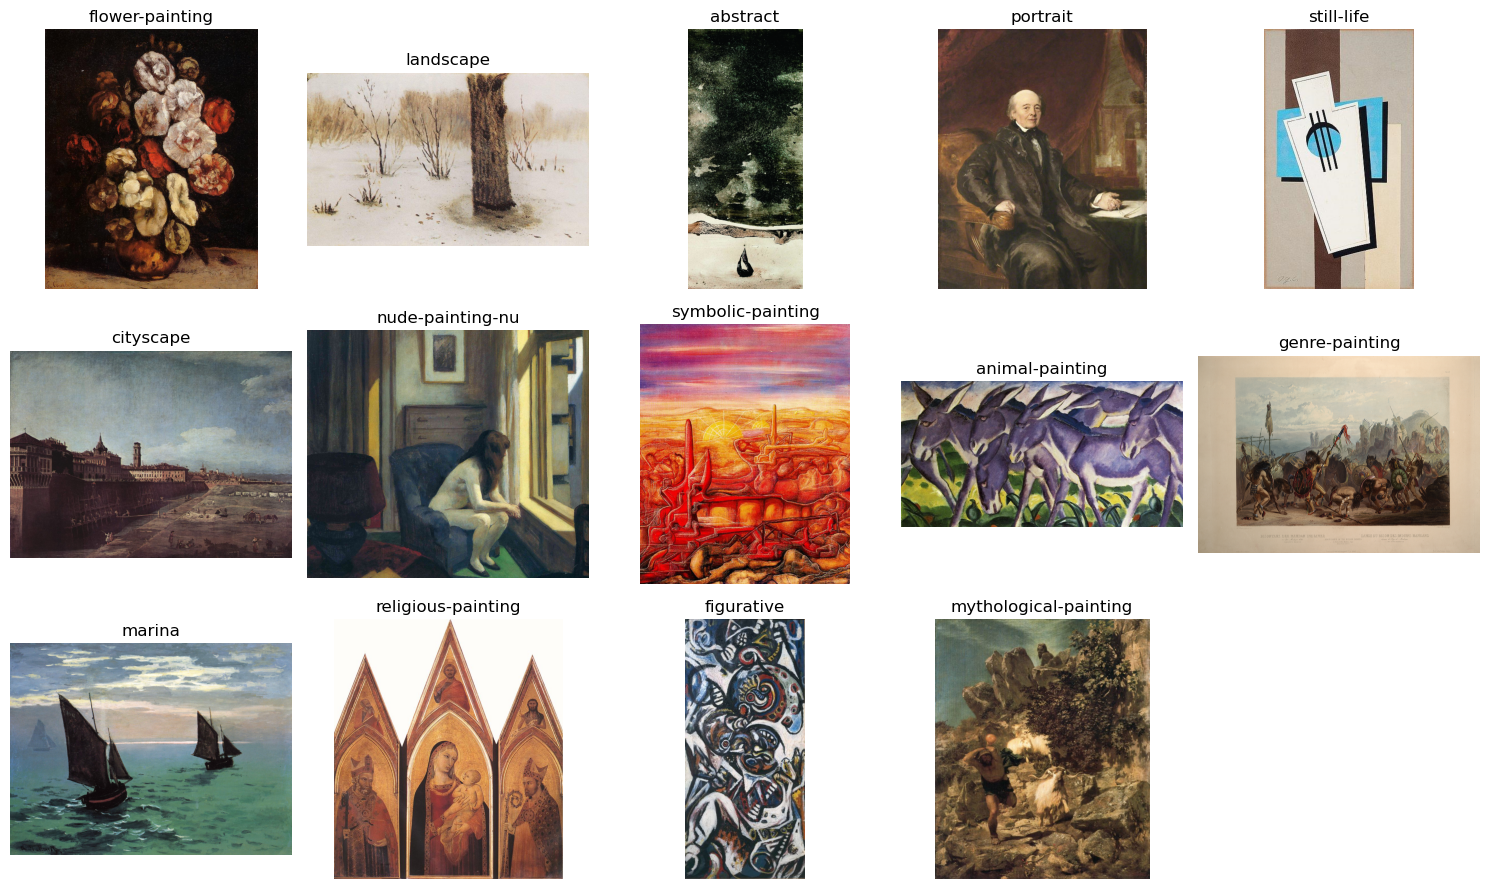

In [10]:
# Preview examples
preview_images = os.listdir(DATASET_PREVIEWS_PATH)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

axes = axes.ravel()

for i, (ax, image_file) in enumerate(zip(axes, preview_images)):
    image_path = os.path.join(DATASET_PREVIEWS_PATH, image_file)
    image = Image.open(image_path)
    image_art_type = image_file.split(".")[0]
    
    ax.imshow(image)
    ax.set_title(f"{image_art_type}")
    ax.axis('off')

# Turn off any remaining empty subplots
for j in range(len(preview_images), 3*5):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = 4

TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.15
TEST_SPLIT = 0.15

transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomGrayscale(p=0.1),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

In [6]:
full_wiki_art_dataset = WikiArtDataset(DATASET_PATH, transform=transforms)

# Split training set
train_size = int(0.8 * len(full_wiki_art_dataset))
temp_size = len(full_wiki_art_dataset) - train_size
train_dataset, temp_dataset = random_split(
    full_wiki_art_dataset, 
    [train_size, temp_size]
)

# Split validation and test set
val_size = int(0.5 * len(temp_dataset))
test_size = len(temp_dataset) - val_size
val_dataset, test_dataset = random_split(
    temp_dataset, 
    [val_size, test_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# Base MAE Implementation

This is an outlined workflow of the training and testing process of the MAE,

1. Masking:
    - For each input image, divide them into patches and randomly select 75% of the patches to mask
2. Encoding:
    - Pass only the visible patches through the encoder
    - The output should be the latent representations for each unmasked patch
3. Decoding:
    - The decoder takes in the encoded masked patches (output of the encoder) and Mask tokens (learnable placeholders for masked patches)
    - Goal is to reconstruct all patches of the input image, including visible patches

![architecture](imgs/architecture.png)

### Input Masking

In a MAE, input images are instead masked or "patched out" from the model during training. Masking is performed by splitting the images into fixed sized patches and randomly selecting 75% of the patches to mask. The motivation of this to not only reconstruct the missing parts of a masked image but to also force the model to learn meaningful representations.

In [12]:
def random_indexes(size):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

In [13]:
class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        
        self.ratio = ratio

    def forward(self, patches):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes

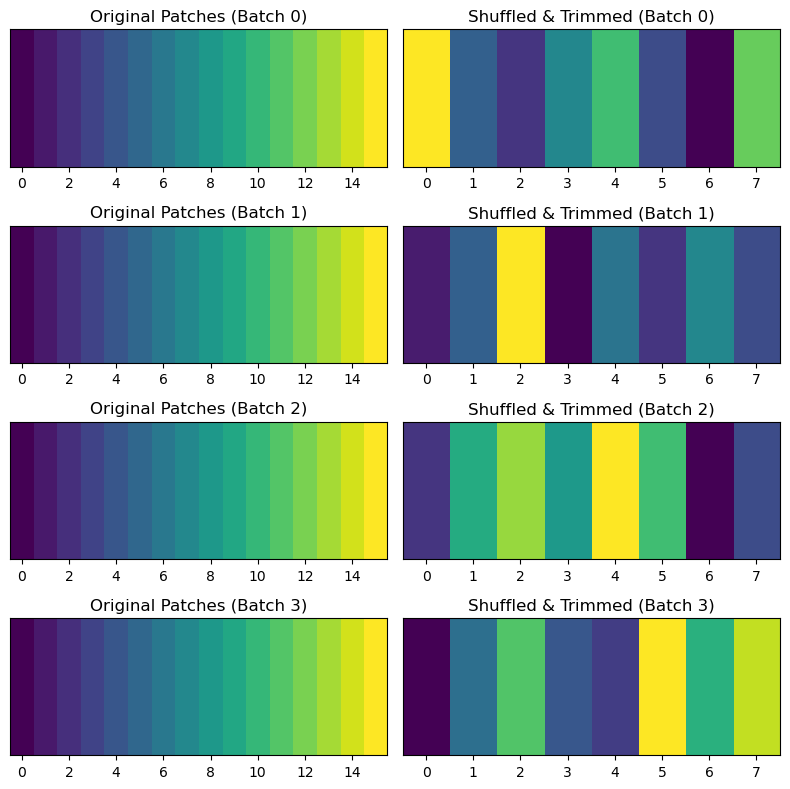

In [8]:
# Simulate patch masker
test_batch = next(iter(train_loader))
test_image = test_batch[0][0].unsqueeze(0)
test_mask_ratio = 0.25
test_patch_size = 16

masker = PatchMasker(mask_ratio=test_mask_ratio, patch_size=test_patch_size)
patches, mask_indices, unmasked_indices = masker(test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


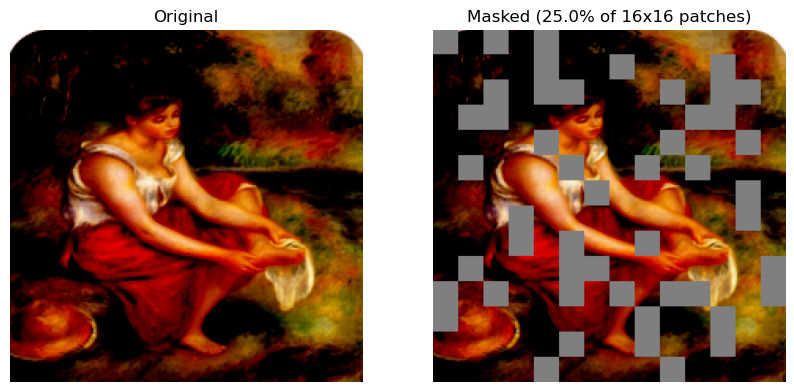

In [9]:
# Create visualization (replace masked patches with gray)
masked_patches = patches.clone()
masked_patches[0, mask_indices[0]] = 0.5

# Reconstruct image from patches
B, C, H, W = test_image.shape
masked_image = rearrange(
    masked_patches,
    'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
    h=H//16,
    w=W//16,
    p1=16,
    p2=16,
    c=C
)

# Visualize side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0].permute(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image[0].permute(1, 2, 0))
plt.title(f"Masked ({100*test_mask_ratio}% of {test_patch_size}x{test_patch_size} patches)")
plt.axis('off')

plt.show()

### Base MAE

In [10]:
class MAE_Encoder(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=768, num_layers=12, num_heads=12):
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        # Patch embedding
        self.patch_embed = nn.Linear(patch_size**2 * in_channels, embed_dim)

        # Positional embeddings and CLS token
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim, dtype=torch.float32))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim, dtype=torch.float32))

        # Transformer
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x_patches, unmasked_indices):
        B = x_patches.shape[0]

        # Extract unmasked patches
        x_unmasked = torch.stack([
            x_patches[b, unmasked_indices[b]] for b in range(B)
        ], dim=0)

        x_unmasked = self.patch_embed(x_unmasked)

        # Add positional embeddings
        pos_embed = self.pos_embed[:, 1:].expand(B, -1, -1)
        pos_embed_unmasked = torch.stack([
            pos_embed[b, unmasked_indices[b]] for b in range(B)
        ], dim=0)
        x_unmasked = x_unmasked + pos_embed_unmasked.to(x_unmasked.dtype)

        # Append cls token
        cls_token = self.cls_token.expand(B, -1, -1).to(x_unmasked.dtype)
        x_unmasked = torch.cat([cls_token, x_unmasked], dim=1)

        # Transformer
        x_encoded = self.blocks(x_unmasked)
        return self.norm(x_encoded)

In [11]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, encoder_embed_dim=768, decoder_embed_dim=512, num_layers=4, num_heads=8):
        super().__init__()

        self.num_patches = (image_size // patch_size) ** 2

        # Project encoder output to decoder dimension
        self.decoder_embed = nn.Linear(encoder_embed_dim, decoder_embed_dim)

        # Positional embeddings and mask token
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim, dtype=torch.float32))
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim, dtype=torch.float32))

        # Decoder transformer
        self.blocks = nn.Sequential(*[Block(decoder_embed_dim, num_heads) for _ in range(num_layers)])
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_channels)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.trunc_normal_(self.mask_token, std=0.02)
        nn.init.trunc_normal_(self.decoder_pos_embed, std=0.02)

    def forward(self, x_encoded, mask_indices, unmasked_indices):
        B = x_encoded.shape[0]

        # Project encoder output
        x_decoder = self.decoder_embed(x_encoded)

        # Prepare full sequence: CLS + unmasked + masked
        x_full = torch.zeros(
            B,
            self.num_patches + 1,
            x_decoder.shape[-1],
            dtype=x_decoder.dtype,
            device=x_decoder.device
        )

        # Set CLS token
        x_full[:, 0] = x_decoder[:, 0]

        # Set unmasked patch tokens
        for b in range(B):
            x_full[b, unmasked_indices[b] + 1] = x_decoder[b, 1:]

        # Insert mask tokens
        mask_tokens = self.mask_token.expand(B, mask_indices.shape[1], -1).to(x_decoder.dtype)
        for b in range(B):
            x_full[b, mask_indices[b] + 1] = mask_tokens[b]

        # Add positional embeddings
        x_full = x_full + self.decoder_pos_embed[:, :x_full.size(1)].to(x_full.dtype)

        # Transformer and prediction
        x_decoded = self.blocks(x_full)
        pred_patches = self.decoder_pred(x_decoded[:, 1:])
        return pred_patches

In [12]:
class MAE(nn.Module):
    def __init__(
        self,
        image_size=224, 
        patch_size=16, 
        in_channels=3,
        encoder_embed_dim=256,
        decoder_embed_dim=128,
        encoder_depth=4,
        decoder_depth=1,
        encoder_heads=4,
        decoder_heads=2,
        mask_ratio=0.75,
    ):
        super().__init__()
        
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size

        # Modules
        self.patch_masker = PatchMasker(mask_ratio, patch_size)
        self.encoder = MAE_Encoder(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=encoder_embed_dim,
            num_layers=encoder_depth,
            num_heads=encoder_heads,
        )
        self.decoder = MAE_Decoder(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            encoder_embed_dim=encoder_embed_dim,
            decoder_embed_dim=decoder_embed_dim,
            num_layers=decoder_depth,
            num_heads=decoder_heads,
        )

    def forward(self, x):
        # 1. Mask the input
        x_patches, mask_indices, unmasked_indices = self.patch_masker(x)

        # 2. Encode visible patches
        x_encoded = self.encoder(x_patches, unmasked_indices)

        # 3. Decode all patches
        pred_patches = self.decoder(x_encoded, mask_indices, unmasked_indices)

        # 4. Reconstruct image
        pred_img = rearrange(
            pred_patches,
            'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=int((x.shape[2] / self.patch_size)),
            w=int((x.shape[3] / self.patch_size)),
            p1=self.patch_size,
            p2=self.patch_size,
            c=x.shape[1],
        )

        return pred_img

In [13]:
def train_mae(model, optimizer, criterion, scaler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch_idx, (images, _) in enumerate(train_loader):
            images = images.cuda()
            optimizer.zero_grad()

            with autocast(dtype=torch.float16):
                reconstructed = model(images)
                loss = criterion(reconstructed, images)

            # Gradient scaling + backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            
            if batch_idx % 100 == 0: print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

        # Save checkpoint every epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'loss': total_loss / len(train_loader),
        }
        torch.save(
            checkpoint, 
            os.path.join(MODEL_DIR, f"mae_epoch_{epoch}.pt")
        )
        print(f"Epoch {epoch}: Loss = {total_loss / len(train_loader):.4f} | Checkpoint saved.")

In [15]:
# Training loop
num_epochs = 10
lr = 1e-4

model = MAE(
    encoder_embed_dim=384,
    decoder_embed_dim=256,
    encoder_depth=6,
    decoder_depth=2,
    encoder_heads=6,
    decoder_heads=4,
).cuda()

optimizer = optim.AdamW(model.parameters(), lr=lr)
scaler = GradScaler()
criterion = nn.MSELoss()

if TRAIN_LOADED_BASE_MODEL:
    checkpoint_model_file = "models\mae_epoch_1.pt"
    checkpoint = torch.load(checkpoint_model_file)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    
elif TRAIN_BASE_MODEL:
    train_mae(
        model, 
        optimizer, 
        criterion, 
        scaler, 
        num_epochs=num_epochs
    )

### Assess Base MAE

In [22]:
def show_reconstructions(model, data_loader, num_images=3):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images[:num_images].cuda()
    
    with torch.no_grad():
        reconstructions = model(images)
    
    # Convert to numpy and properly format
    original_imgs = images.cpu().numpy()
    recon_imgs = reconstructions.cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original
        plt.subplot(2, num_images, i+1)
        plt.imshow(np.transpose(original_imgs[i], (1, 2, 0)))
        plt.title(f"Original {i+1}")
        plt.axis('off')
        
        # Reconstruction
        plt.subplot(2, num_images, i+num_images+1)
        plt.imshow(np.transpose(recon_imgs[i], (1, 2, 0)))
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


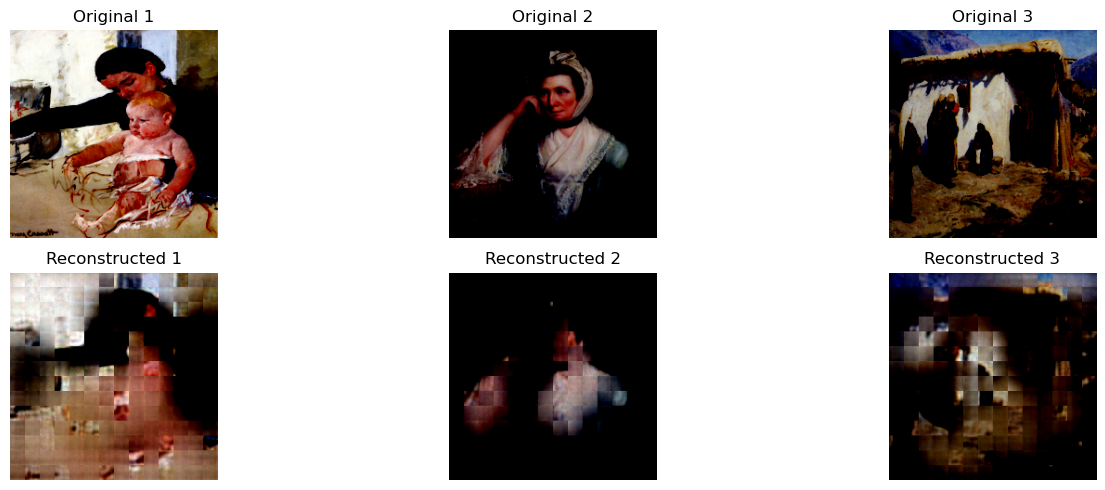

In [23]:
checkpoint_model_file = "models\mae_epoch_2.pt"
checkpoint = torch.load(checkpoint_model_file)

checkpoint_model = MAE(
    encoder_embed_dim=384,
    decoder_embed_dim=256,
    encoder_depth=6,
    decoder_depth=2,
    encoder_heads=6,
    decoder_heads=4,
).cuda()

checkpoint_model.load_state_dict(checkpoint['model_state_dict'])

show_reconstructions(checkpoint_model, val_loader, num_images=3)

# Final MAE Implementation